# Running SCENIC+

This tutorial will illustrate how to run the SCENIC+ pipeline via Snakemake.

Before running this pipeline you should:

- Preprocess the scATAC-seq side of the data using [pycisTopic](https://github.com/aertslab/pycisTopic), [click here](...) for a tutorial.
- Preprocess the scRNA-seq side of the data using [Scanpy](https://github.com/scverse/scanpy), [click here](...) for a tutorial.
- Optionally, but highly recommended, generate a cisTarget database using the consensus peaks specific to your dataset, [click here](...) for a tutorial.

In case you have human, mouse or fly data you can also use one of the precomputed cisTarget databases. These can be found on our [resources website](https://resources.aertslab.org/cistarget/databases/).

In [1]:
import os
os.chdir("/staging/leuven/stg_00002/lcb/sdewin/PhD/python_modules/scenicplus_development_tutorial")

SCENIC+ can be run entirely using the command line. Please refer to the docummentation (by using the `--help` flag) for more information.

Below we will use the Snakemake pipeline, which is already included in SCENIC+ to perform the analysis.

In [3]:
!scenicplus


   ____   ____ _____ _   _ ___ ____      
  / ___| / ___| ____| \ | |_ _/ ___| _ 
  \___ \| |   |  _| |  \| || | |   _|.|_
   ___) | |___| |___| |\  || | |__|_..._|
  |____/ \____|_____|_| \_|___\____||_| 


scenicplus verions: 1.0a1
usage: scenicplus [-h] {init_snakemake,prepare_data,grn_inference} ...

Single-Cell Enhancer-driven gene regulatory Network Inference and Clustering

positional arguments:
  {init_snakemake,prepare_data,grn_inference}

options:
  -h, --help            show this help message and exit


### scRNA-seq preparation

scRNA-seq side of the experiment can be processed according to the regular [Scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) tutorial. Just make sure to store the raw gene expresison matrix in `adata.raw`.

**Call the following piece of code:**

```python

adata.raw = adata

```

**_BEFORE_** normalizing the data

```python

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

```

In [41]:
ls data

10x_multiome_brain_cisTopicObject_noDBL.pkl@  adata.h5ad@  region_sets/


## Initialize Snakemake

To run Snakemake we first have to initialize the pipeline. This will create a folder named `Snakemake` containing a folder for the `config.yaml` file and a folder containing the actual workflow definition.

In [45]:
!mkdir -p scplus_pipeline
!scenicplus init_snakemake --out_dir scplus_pipeline

2024-03-06 14:28:10,766 SCENIC+      INFO     Creating snakemake folder in: scplus_pipeline


In [51]:
!tree scplus_pipeline/

scplus_pipeline/
└── Snakemake
    ├── config
    │   └── config.yaml
    └── workflow
        └── Snakefile

3 directories, 2 files


In [2]:
!mkdir -p outs
!mkdir -p tmp

Next, modify the `config.yaml` file.

The most important fields are `input_data` and `output_data`. For the other default values can be kept:

**input_data**:
This is the input to the pipeline, these files should already exist.

- `cisTopic_obj_fname`: the path to your cistopic object containing processed chromatin accessibility data.
- `GEX_anndata_fname`: the path to your scanpy h5ad file containing processed gene expression data.
- `region_set_folder`: the path to directory containing several directories with bed files. Differential motif enrichment (1 vs all) will be run within each sub folder. As an example the structure of the folder is shown below.
- `ctx_db_fname`: the path to the cisTarget **ranking** database.
- `dem_db_fname`: the path to the cisTarget **score** database.
- `path_to_motif_annotations`: the path to the motif-to-TF annotaiton. For human (hgnc), mouse (mgi), chicken and fly (flybase) these files can be downloaded from [our resources website](https://resources.aertslab.org/cistarget/motif2tf/), please download the relevant file starting with "motifs-v10nr_clust".

**output_data**:
This is the output of the pipeline, these files will be created.
If some of these files already exists (for example when the pipeline has only been partially run) some steps of the workflow might be skipped.

- `combined_GEX_ACC_mudata`: where the [MuData](https://github.com/scverse/mudata) object containing gene expression and imputed chromatin accessibility should be stored.
- `dem_result_fname`: where the h5 file containing DEM based enriched motifs should be stored.
- `ctx_result_fname`: where the h5 file containing cistarget based enriched motifs should be stored.
- `output_fname_dem_html`: where the html file containing DEM based enriched motifs should be stored.
- `output_fname_ctx_html`: where the html file containing cistarget based enriched motifs should be stored.
- `cistromes_direct`: where the [AnnData](https://github.com/scverse/anndata) h5ad file should be stored containing TF-to-region links based on direct motif-to-TF annotations.
- `cistromes_extended`: where the [AnnData](https://github.com/scverse/anndata) h5ad file should be stored containing TF-to-region links based on exteded (e.g. orthology based) motif-to-TF annotations.
- `tf_names`: where a text file containing TF names, based on the enriched motifs, should be stored.
- `genome_annotation`: where a data frame (tsv) should be stored containing genome annotation.
- `chromsizes`: where the chromsizes file should be stored.
- `search_space`: where the search space for each gene should be stored.
- `tf_to_gene_adjacencies`: where the TF-to-gene links, with importance scores, should be stored.
- `region_to_gene_adjacencies`: where the region-to-gene links, with importance scores, should be stored.
- `eRegulons_direct`: where the dataframe (tsv) containing eRegulons (TF-region-gene links) based on direct motif-to-TF annotations should be stored.
- `eRegulons_extended`: where the dataframe (tsv) containing eRegulons (TF-region-gene links) based on extended (e.g. orthology based) motif-to-TF annotations should be stored.
- `AUCell_direct`: where the [MuData](https://github.com/scverse/mudata) containing target gene and target region enrichement scores for each cells, based on direct motif-to-TF annotations should be stored.
- `AUCell_extended`: where the [MuData](https://github.com/scverse/mudata) containing target gene and target region enrichement scores for each cells, based on extended (e.g. orthology based) motif-to-TF annotations should be stored.
- `scplus_mdata`: where the final output [MuData](https://github.com/scverse/mudata) containing AUCell values and the (TF-region-gene links) based on both direct and extended motif-to-TF annotations should be stored.

**params_general**
General parameters.
- `temp_dir`: Directory to store temporary data.
- `n_cpu`: maximum number of CPU's to use.
- `seed`: seed to use to initialize the random state.

**params_data_preparation**
Parameters used for the data preparation step.
- `bc_transform_func`: lambda function to transform the scRNA-seq barcode so they match with the scATAC-seq ones
- `is_multiome`: boolean specifying wether the data is multiome or not.
- `key_to_group_by`: in case of non-multiome data, cell metadata variable to group cells by in order to generate metacells that can be matched across the scRNA-seq and scATAC-seq side of the data. This variable should be prefixed with eiter "GEX:" or "ACC:".
- `nr_cells_per_metacells`: in case of non-multione data, number of cells to sample to sample for each metacell.
- `direct_annotation`: Which annotations fields to use for generating direct motif-to-TF annotations.
- `extended_annotation`: Which annotations fields to use for generating extended motif-to-TF annotations
- `species`: Species name, for example "hsapiens"
- `biomart_host`: Biomart host to use for downloading genome annotations. Make sure that this host matches the genome reference you are using, please visit [this website](https://www.ensembl.org/info/website/archives/index.html) for more information.
- `search_space_upstream`: string in the form "\<minmal\> \<maximal\>" specifying the \<minimal\> and \<maximal\> search space to consider downstream of the TSS of each gene.
- `search_space_downstream`: string in the form "\<minmal\> \<maximal\>" specifying the \<minimal\> and \<maximal\> search space to consider upstrean of the TSS of each gene.
- `search_space_extend_tss`: string in the form "\<upstream\> \<downstream\>" specifying the amount of basepairs the TSS of each gene should be extended, \<upstream\>  and 

**params_motif_enrichment**
parameters for performing motif enrichment analysis.
- `species`: Species used for the analysis. This parameter is used to download the correct motif-to-TF annotations from the cisTarget webservers.
- `annotation_version`: Version of the motif-to-TF annotation to use. This parameter is used to download the correct motif-to-TF data from the cisTarget webservers.
- `motif_similarity_fdr`: Threshold on motif similarity scores for calling similar motifs.
- `orthologous_identity_threshold`: Threshold on the protein-protein orthology score for calling orthologous motifs
- `annotations_to_use`: Which annotations to use for annotation motifs to TFs.
- `fraction_overlap_w_dem_database`: Fraction of nucleotides, of regions in the bed file, that should overlap with regions in the scores database.
- `dem_max_bg_regions`: Maximum number of regions to use as background for DEM.
- `dem_balance_number_of_promoters`: Boolean specifying wether the number of promoters should be equalized between the foreground and background set of regions.
- `dem_promoter_space`: Number of basepairs up- and downstream of the TSS that are considered as being the promoter for that gene.
- `dem_adj_pval_thr`: Threshold on the Benjamini-Hochberg adjusted p-value from the Wilcoxon test performed on the motif score of foreground vs background regions for a motif to be considered as enriched.
- `dem_log2fc_thr`: Threshold on the log2 fold change of the motif score of foreground vs background regions for a motif to be considered as enriched.
- `dem_mean_fg_thr`: Minimul mean signal in the foreground to consider a motif enriched for DEM.
- `dem_motif_hit_thr`: Minimal CRM score to consider a region enriched for a motif for DEM.
- `fraction_overlap_w_ctx_database`: Fraction of nucleotides, of regions in the bed file, that should overlap with regions in the ranking database.
- `ctx_auc_threshold`: Threshold on the AUC value for calling significant motifs
- `ctx_nes_threshold`: Threshold on the NES value for calling significant motifs.
- `ctx_rank_threshold`: The total number of ranked regions to take into account when creating a recovery curves.

**params_inference**
Parameters for performing GRN inference.
- `tf_to_gene_importance_method`: Method to use to calculate TF-to-gene importance scores.
- `region_to_gene_importance_method`: Method to use to calculate region-to-gene importance scores.
- `region_to_gene_correlation_method`: Method to use to calculate region-to-gene correlation coefficients.
- `order_regions_to_genes_by`: Value to order region-to-gene scores by for selecting top regions per gene
- `order_TFs_to_genes_by`: value to order TF-to-gene scores by for selecting top TFs per gene
- `gsea_n_perm`: Number or permutations to perform for calculating GSEA enrichment scores.
- `quantile_thresholds_region_to_gene`: space seperated list containing quantile threshold to be used for binarizing region-to-gene links.
- `top_n_regionTogenes_per_gene`: space seperated list containing the number of top regions per gene for binarizing region-to-gene links.
- `top_n_regionTogenes_per_region`: space seperated list containging per region the number of top genes for binarizing region-to-gene links
- `min_regions_per_gene`: minimum number of regions per gene for the link to be included in eGRNs.
- `rho_threshold`: absolute threshold on the correlation coefficient to seperate positive and negative region-to-gene and TF-to-gene links
- `min_target_genes`: minimum number of target genes per TF for the link(s) to be includedin eGRNs.


In [1]:
!tree /staging/leuven/stg_00002/lcb/sdewin/PhD/python_modules/pycisTopic_polars_tutorial/outs/region_sets

/staging/leuven/stg_00002/lcb/sdewin/PhD/python_modules/pycisTopic_polars_tutorial/outs/region_sets
├── DARs_cell_type
│   ├── AST.bed
│   ├── BG.bed
│   ├── COP.bed
│   ├── ENDO.bed
│   ├── GC.bed
│   ├── GP.bed
│   ├── INH_PVALB.bed
│   ├── INH_SNCG.bed
│   ├── INH_SST.bed
│   ├── INH_VIP.bed
│   ├── MG.bed
│   ├── MGL.bed
│   ├── MOL.bed
│   ├── NFOL.bed
│   ├── OPC.bed
│   └── PURK.bed
├── Topics_otsu
│   ├── Topic1.bed
│   ├── Topic10.bed
│   ├── Topic11.bed
│   ├── Topic12.bed
│   ├── Topic13.bed
│   ├── Topic14.bed
│   ├── Topic15.bed
│   ├── Topic16.bed
│   ├── Topic17.bed
│   ├── Topic18.bed
│   ├── Topic19.bed
│   ├── Topic2.bed
│   ├── Topic20.bed
│   ├── Topic21.bed
│   ├── Topic22.bed
│   ├── Topic23.bed
│   ├── Topic24.bed
│   ├── Topic25.bed
│   ├── Topic26.bed
│   ├── Topic27.bed
│   ├── Topic28.bed
│   ├── Topic29.bed
│   ├── Topic3.bed
│   ├── Topic30.bed
│   ├── Topic31.bed
│   ├── Topic32.bed
│   ├── Topic33.bed
│   ├── Topic34.bed
│   ├── Topic35.bed
│   ├── Topic3

In [122]:
!bat scplus_pipeline/Snakemake/config/config.yaml

───────┬────────────────────────────────────────────────────────────────────────
       │ File: scplus_pipeline/Snakemake/config/config.yaml
───────┼────────────────────────────────────────────────────────────────────────
   1   │ input_data:
   2   │   cisTopic_obj_fname: "/staging/leuven/stg_00002/lcb/sdewin/PhD/python_
       │ modules/pycisTopic_polars_tutorial/outs/cistopic_obj.pkl"
   3   │   GEX_anndata_fname: "/staging/leuven/stg_00002/lcb/sdewin/PhD/python_m
       │ odules/scenicplus_development_tutorial/data/adata.h5ad"
   4   │   region_set_folder: "/staging/leuven/stg_00002/lcb/sdewin/PhD/python_m
       │ odules/pycisTopic_polars_tutorial/outs/region_sets"
   5   │   ctx_db_fname: "/staging/leuven/stg_00002/lcb/sdewin/PhD/python_module
       │ s/scenicplus_development_tutorial/ctx_db/10x_brain_1kb_bg_with_mask.reg
       │ ions_vs_motifs.rankings.feather"
   6   │   dem_db_fname: "/staging/leuven/stg_00002/lcb/sdewin/PhD/python_module
       │ s/scenicplus_development_tu

## Run pipeline

Once the config file is filled in the pipeline can be run.

In [7]:
cd scplus_pipeline/Snakemake/

In [8]:
ls

config	workflow


In [14]:
source /staging/leuven/stg_00002/mambaforge/vsc33053/etc/profile.d/conda.sh
conda activate scenicplus_development_tutorial
snakemake --cores 20

Assuming unrestricted shared filesystem usage for local execution.
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 20
Rules claiming more threads will be scaled down.
Job stats:
job                            count
---------------------------  -------
AUCell_direct                      1
AUCell_extended                    1
all                                1
download_genome_annotations        1
eGRN_direct                        1
eGRN_extended                      1
get_search_space                   1
motif_enrichment_cistarget         1
motif_enrichment_dem               1
prepare_menr                       1
region_to_gene                     1
scplus_mudata                      1
tf_to_gene                         1
total                             13

Select jobs to execute...
Execute 1 jobs...

[Mon Mar 11 15:16:45 2024]
localrule motif_enrichment_cistarget:
    input: /staging/leuven/stg_00002/lcb/sdewin/PhD/python_modules/scenicplus_development_tutorial/d

## Main outputs

The main output of the pipeline is the `scplusmdata.h5mu` file. This is a MuData file containing the eRegulons and enrichment scores.

In [125]:
import os
os.chdir("/staging/leuven/stg_00002/lcb/sdewin/PhD/python_modules/scenicplus_development_tutorial")

In [126]:
import mudata
scplus_mdata = mudata.read("outs/scplusmdata.h5mu")

/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/s

Direct and extended predicted TF-to-region-to-gene links. This dataframe contains also a ranking of each TF-region-gene triplet, based on its importance `triplet_rank`.

In [127]:
scplus_mdata.uns["direct_e_regulon_metadata"]

Region    Gene  importance_R2G   rho_R2G  \
0       chr20:35305658-35306158  CEP250        0.020002  0.056479   
1        chr4:41408947-41409447   UCHL1        0.039919  0.278051   
2     chr10:133327408-133327908    CALY        0.021935  0.542038   
3      chr1:239814303-239814803   CHRM3        0.054480  0.731600   
4       chr10:13987335-13987835  FRMD4A        0.002173  0.372226   
...                         ...     ...             ...       ...   
7648    chr12:78102733-78103233    NAV3        0.061226 -0.598159   
7649    chr18:36376597-36377097   FHOD3        0.006648 -0.060058   
7650    chr14:77307021-77307521   TMED8        0.011415 -0.258848   
7651  chr14:103019978-103020478   TRAF3        0.035434 -0.251028   
7652    chr12:20587950-20588450   PDE3A        0.018121 -0.314249   

      importance_x_rho  importance_x_abs_rho      TF  is_extended  \
0             0.001130              0.001130  BCL11A        False   
1             0.011099              0.011099  BCL11A        False   
2             0.011889              0.011889  BCL11A        False   
3             0.039857              0.039857  BCL11A        False   
4             0.000809              0.000809  BCL11A        False   
...                ...                   ...     ...          ...   
7648         -0.036623              0.036623   TCF12        False   
7649         -0.000399              0.000399   TCF12        False   
7650         -0.002955              0.002955   TCF12        False   
7651         -0.008895              0.008895   TCF12        False   
7652         -0.005695              0.005695   TCF12        False   

          eRegulon_name       Gene_signature_name     Region_signature_name  \
0     BCL11A_direct_+/+  BCL11A_direct_+/+_(352g)  BCL11A_direct_+/+_(641r)   
1     BCL11A_direct_+/+  BCL11A_direct_+/+_(352g)  BCL11A_direct_+/+_(641r)   
2     BCL11A_direct_+/+  BCL11A_direct_+/+_(352g)  BCL11A_direct_+/+_(641r)   
3     BCL11A_direct_+/+  BCL11A_direct_+/+_(352g)  BCL11A_direct_+/+_(641r)   
4     BCL11A_direct_+/+  BCL11A_direct_+/+_(352g)  BCL11A_direct_+/+_(641r)   
...                 ...                       ...                       ...   
7648   TCF12_direct_-/-   TCF12_direct_-/-_(123g)   TCF12_direct_-/-_(136r)   
7649   TCF12_direct_-/-   TCF12_direct_-/-_(123g)   TCF12_direct_-/-_(136r)   
7650   TCF12_direct_-/-   TCF12_direct_-/-_(123g)   TCF12_direct_-/-_(136r)   
7651   TCF12_direct_-/-   TCF12_direct_-/-_(123g)   TCF12_direct_-/-_(136r)   
7652   TCF12_direct_-/-   TCF12_direct_-/-_(123g)   TCF12_direct_-/-_(136r)   

      importance_TF2G  regulation  rho_TF2G  triplet_rank  
0            0.743348           1  0.149413          1879  
1            1.572051           1  0.309145          1767  
2            0.934755           1  0.369021          7337  
3            1.682106           1  0.497771          4406  
4            0.764116           1  0.411129          6392  
...               ...         ...       ...           ...  
7648         5.374822          -1 -0.474900           791  
7649         1.216466          -1 -0.411142          4699  
7650         1.879806          -1 -0.217667          6561  
7651         1.481711          -1 -0.183403          5162  
7652         2.102950          -1 -0.393440          2064  

[7653 rows x 15 columns]

In [128]:
scplus_mdata.uns["extended_e_regulon_metadata"]

Region      Gene  importance_R2G   rho_R2G  \
0          chr1:6475533-6476033  TNFRSF25        0.019441  0.217651   
1      chr2:241803041-241803541     ATG4B        0.015792  0.066621   
2        chr2:42101928-42102428      EML4        0.037126  0.276649   
3     chr10:114303963-114304463     TDRD1        0.082349  0.078376   
4       chr19:18161129-18161629     IFI30        0.027840  0.106714   
...                         ...       ...             ...       ...   
6137    chr22:25436989-25437489      GRK3        0.003550 -0.114036   
6138  chr12:104340926-104341426    CHST11        0.001517 -0.152301   
6139    chr20:41184836-41185336      ZHX3        0.001790 -0.133616   
6140     chr5:66827771-66828271     MAST4        0.002882 -0.218997   
6141    chr15:34337164-34337664   GOLGA8A        0.026024 -0.375745   

      importance_x_rho  importance_x_abs_rho     TF  is_extended  \
0             0.004231              0.004231   EGR3         True   
1             0.001052              0.001052   EGR3         True   
2             0.010271              0.010271   EGR3         True   
3             0.006454              0.006454   EGR3         True   
4             0.002971              0.002971   EGR3         True   
...                ...                   ...    ...          ...   
6137         -0.000405              0.000405  TCF12         True   
6138         -0.000231              0.000231  TCF12         True   
6139         -0.000239              0.000239  TCF12         True   
6140         -0.000631              0.000631  TCF12         True   
6141         -0.009779              0.009779  TCF12         True   

           eRegulon_name        Gene_signature_name  \
0      EGR3_extended_+/+    EGR3_extended_+/+_(24g)   
1      EGR3_extended_+/+    EGR3_extended_+/+_(24g)   
2      EGR3_extended_+/+    EGR3_extended_+/+_(24g)   
3      EGR3_extended_+/+    EGR3_extended_+/+_(24g)   
4      EGR3_extended_+/+    EGR3_extended_+/+_(24g)   
...                  ...                        ...   
6137  TCF12_extended_-/-  TCF12_extended_-/-_(174g)   
6138  TCF12_extended_-/-  TCF12_extended_-/-_(174g)   
6139  TCF12_extended_-/-  TCF12_extended_-/-_(174g)   
6140  TCF12_extended_-/-  TCF12_extended_-/-_(174g)   
6141  TCF12_extended_-/-  TCF12_extended_-/-_(174g)   

          Region_signature_name  importance_TF2G  regulation  rho_TF2G  \
0       EGR3_extended_+/+_(30r)         1.070784           1  0.231038   
1       EGR3_extended_+/+_(30r)         1.234643           1  0.074444   
2       EGR3_extended_+/+_(30r)         1.235069           1  0.202865   
3       EGR3_extended_+/+_(30r)         0.865910           1  0.071393   
4       EGR3_extended_+/+_(30r)         0.962073           1  0.354533   
...                         ...              ...         ...       ...   
6137  TCF12_extended_-/-_(202r)         1.927643          -1 -0.302335   
6138  TCF12_extended_-/-_(202r)         1.120303          -1 -0.326319   
6139  TCF12_extended_-/-_(202r)         1.006590          -1 -0.296368   
6140  TCF12_extended_-/-_(202r)         2.580701          -1 -0.420271   
6141  TCF12_extended_-/-_(202r)         2.319901          -1 -0.286801   

      triplet_rank  
0             4058  
1             5455  
2             2496  
3             1707  
4             3209  
...            ...  
6137          4648  
6138          4314  
6139          3888  
6140          2502  
6141          2936  

[6142 rows x 15 columns]

## Downstream analysis

## eRegulon dimensionality reduction

The eRegulon enrichment scores can be used to perform dimensionality reductions

In [130]:
import scanpy as sc 
import anndata
eRegulon_gene_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"]],
    axis = 1,
)

In [131]:
eRegulon_gene_AUC.obs = scplus_mdata.obs.loc[eRegulon_gene_AUC.obs_names]

In [132]:
sc.pp.neighbors(eRegulon_gene_AUC, use_rep = "X")

In [133]:
sc.tl.umap(eRegulon_gene_AUC)

/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


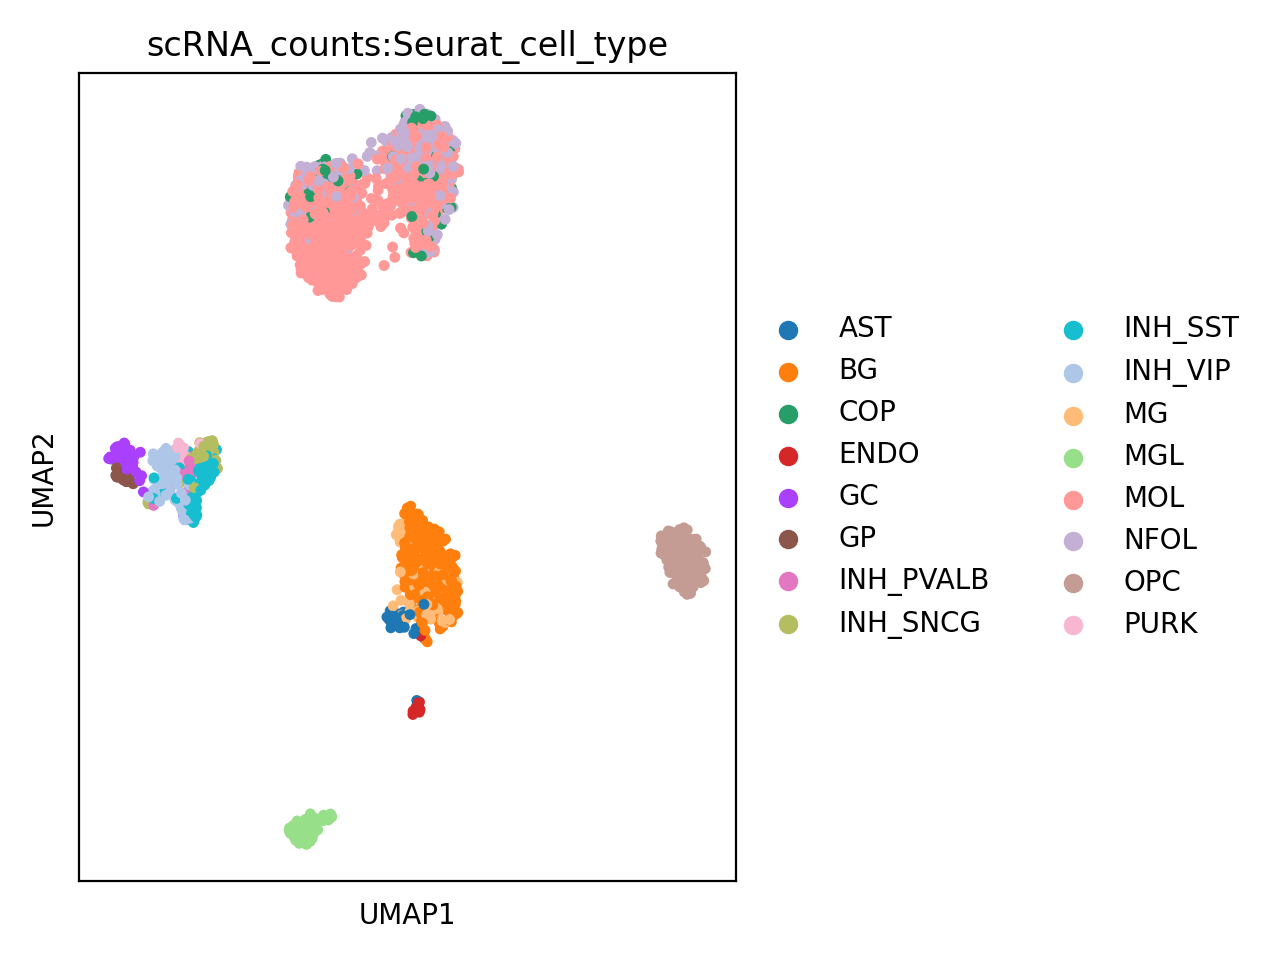

In [134]:
sc.pl.umap(eRegulon_gene_AUC, color = "scRNA_counts:Seurat_cell_type")

## eRegulon specificity score

In [135]:
from scenicplus.RSS import (regulon_specificity_scores, plot_rss)

In [136]:
rss = regulon_specificity_scores(
    scplus_mudata = scplus_mdata,
    variable = "scRNA_counts:Seurat_cell_type",
    modalities = ["direct_gene_based_AUC", "extended_gene_based_AUC"]
)

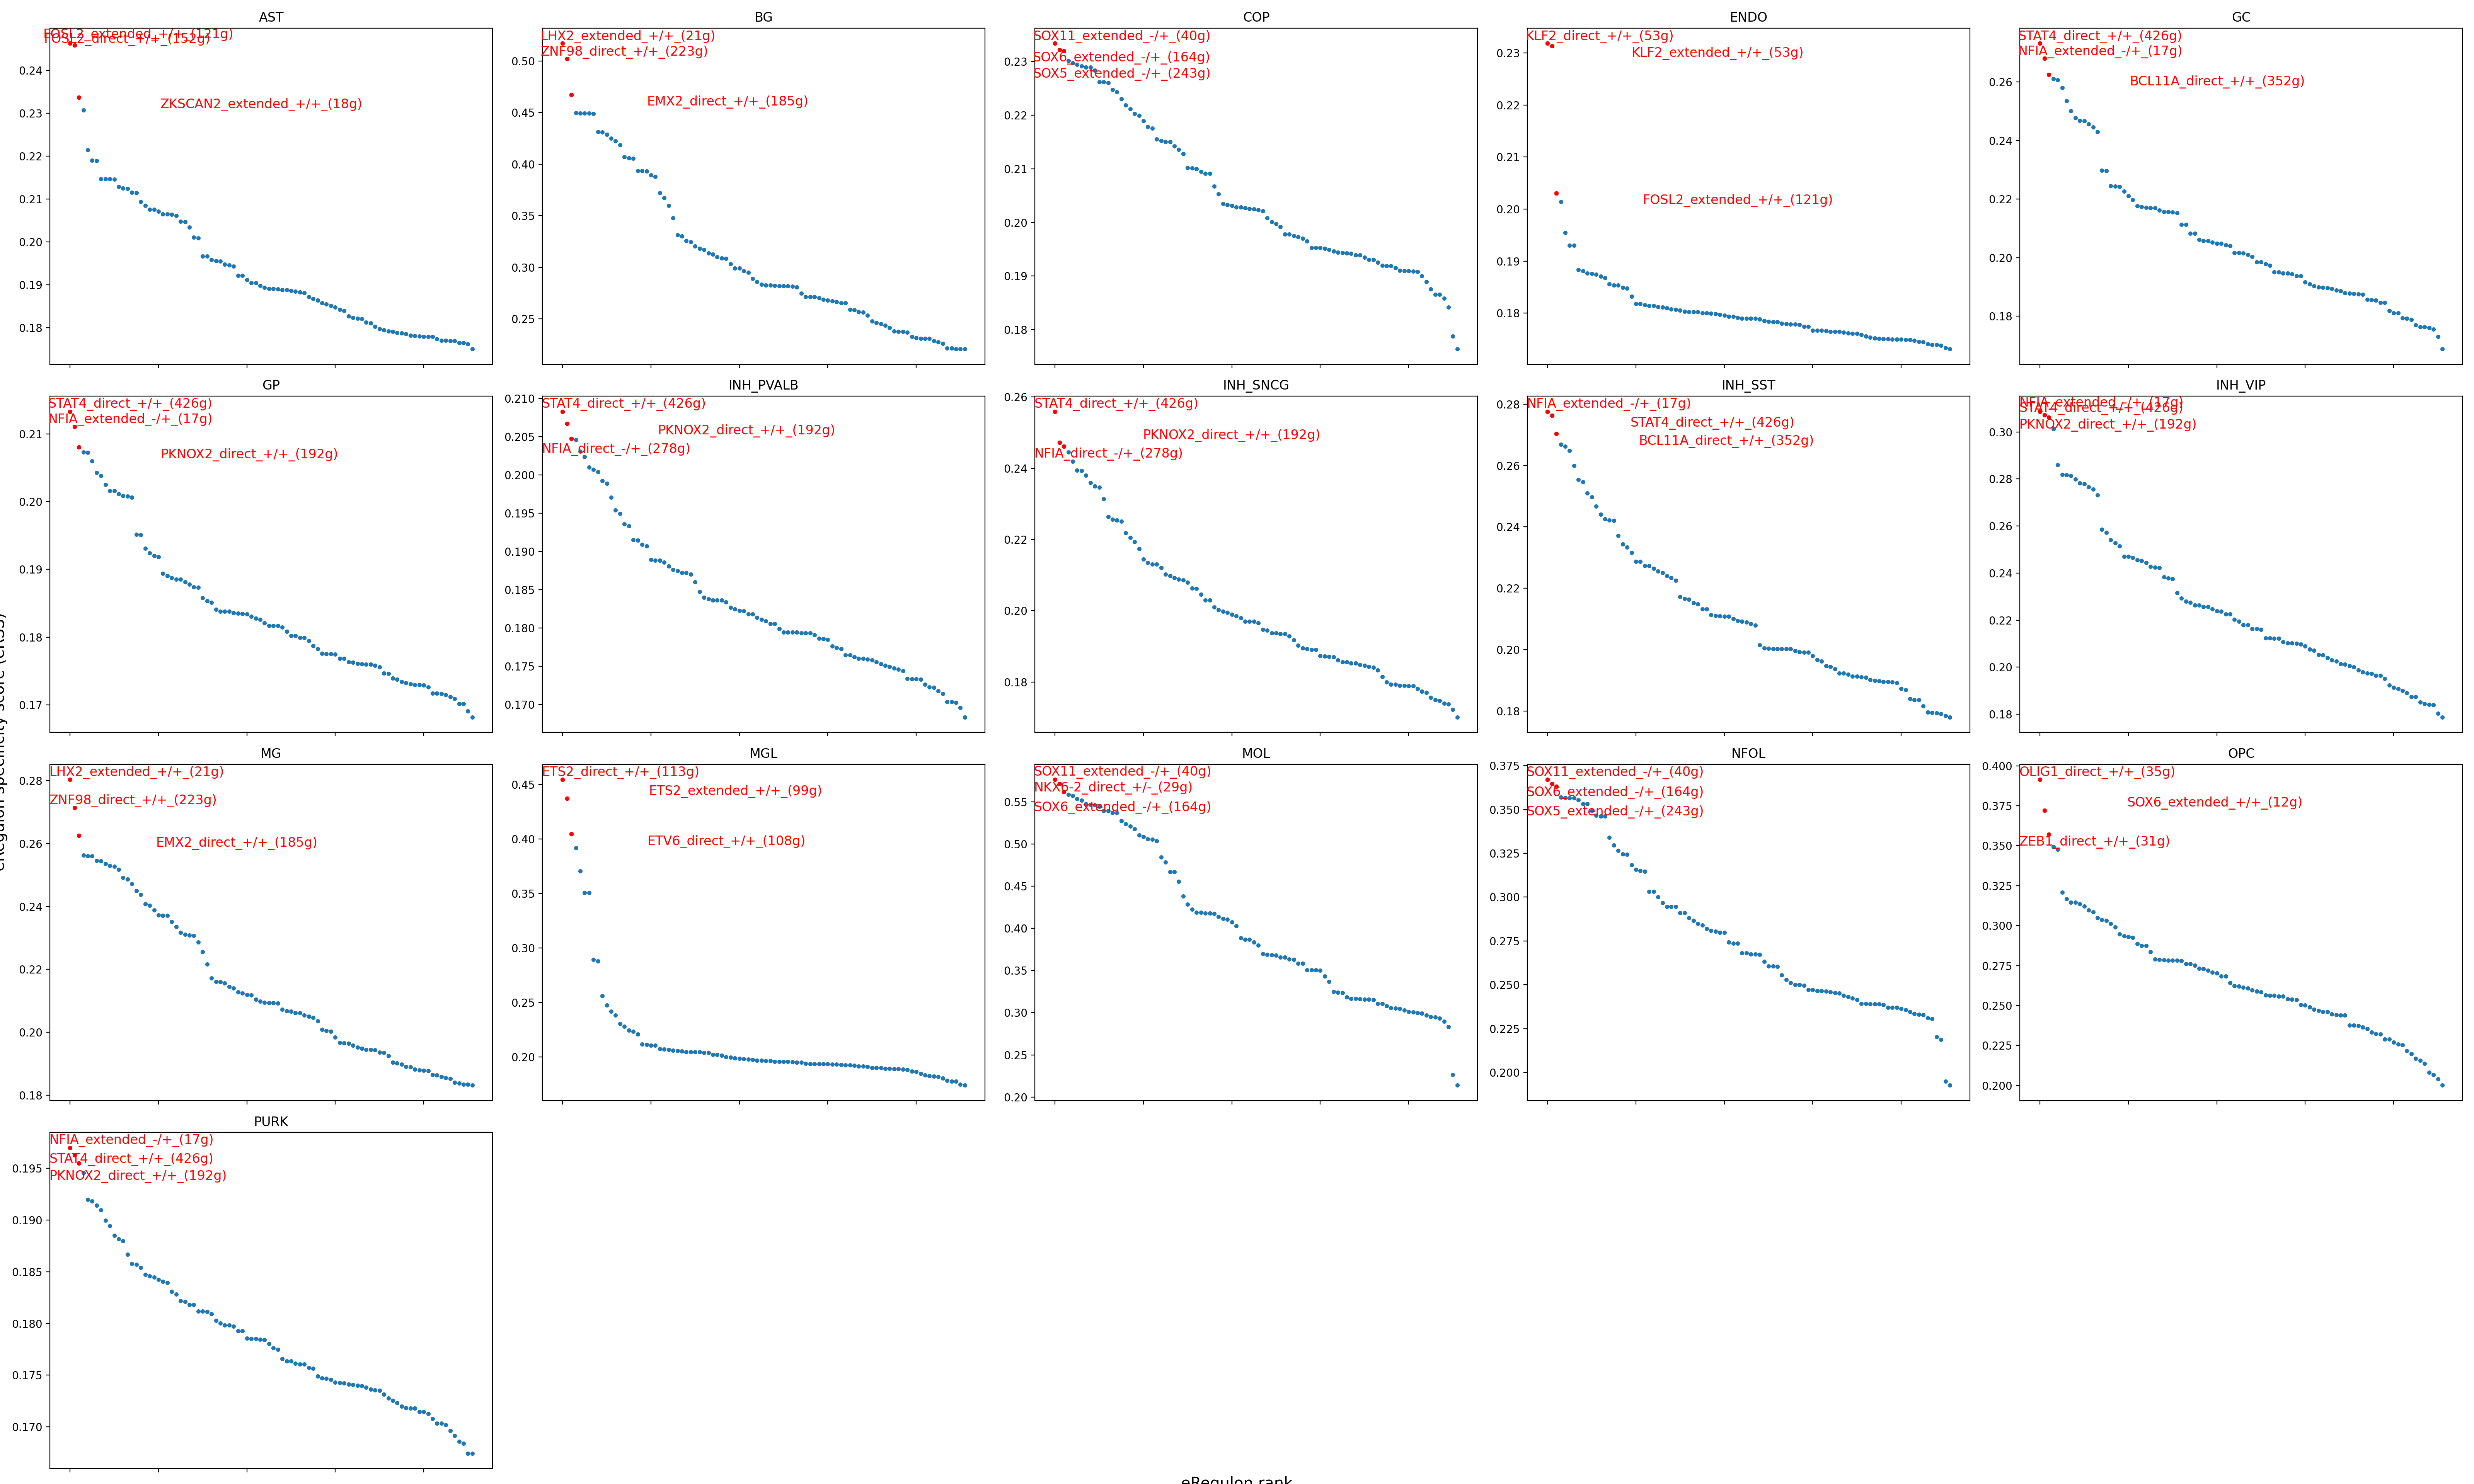

In [137]:
plot_rss(
    data_matrix = rss,
    top_n = 3,
    num_columns = 5
)

## Plot eRegulon enrichment scores

eRegulon enrichment scores can be plotted on the UMAP.

/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


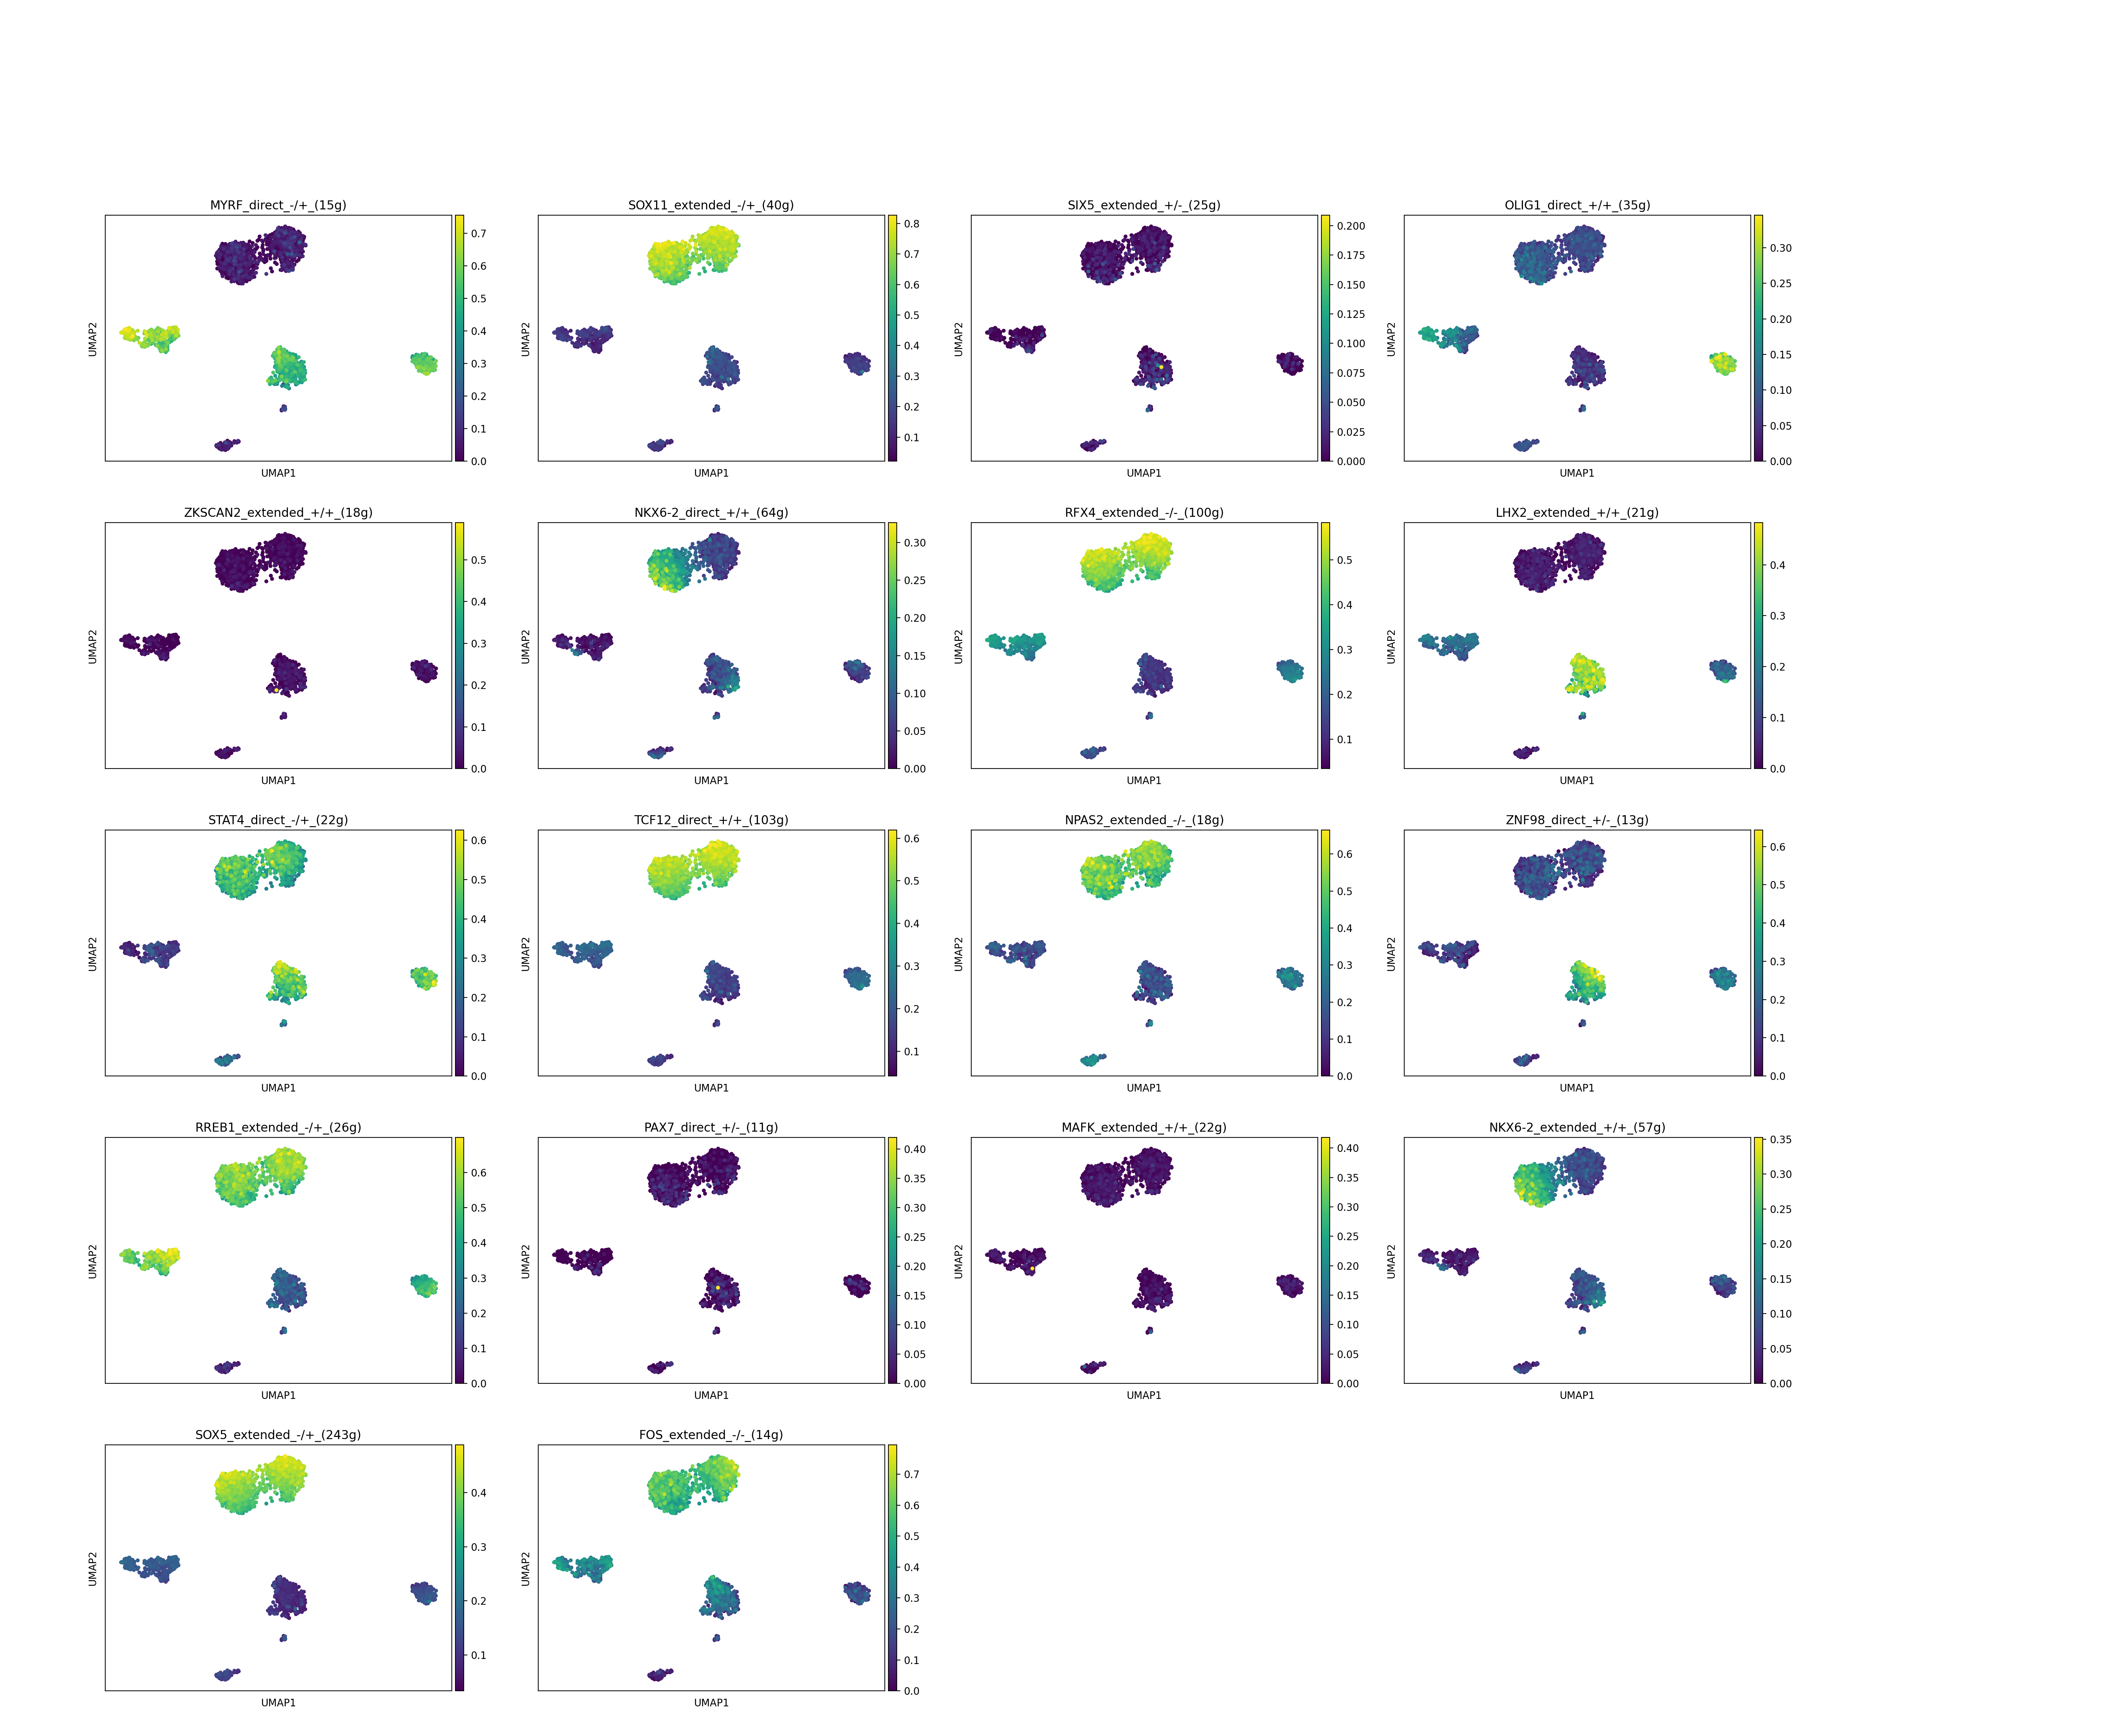

In [138]:
sc.pl.umap(eRegulon_gene_AUC, color = list(set([x for xs in [rss.loc[ct].sort_values()[0:2].index for ct in rss.index] for x in xs ])))

## Heatmap dotplot

We can draw a heatmap where the color represent target gene enrichment and the dotsize target region enrichment.

In [142]:
from scenicplus.plotting.dotplot import heatmap_dotplot

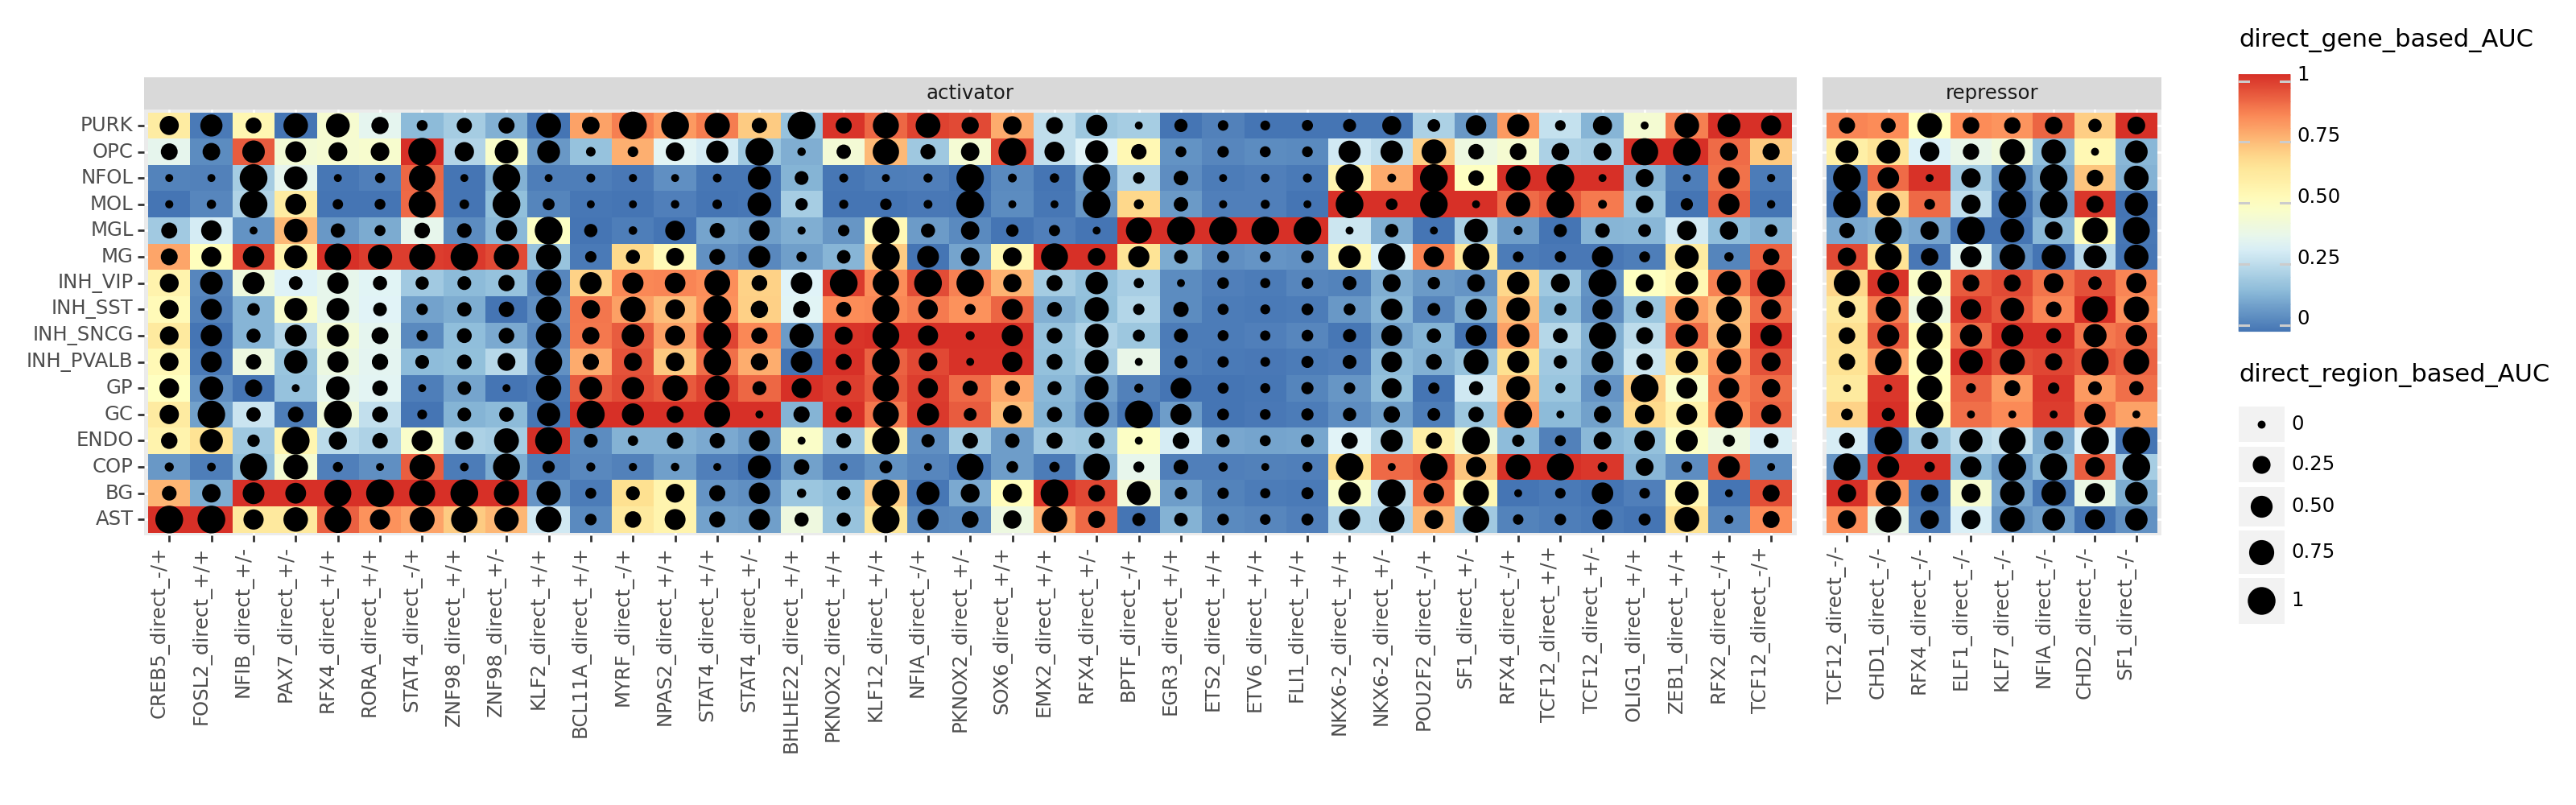

<Figure Size: (1600 x 500)>

In [143]:
heatmap_dotplot(
    scplus_mudata = scplus_mdata,
    color_modality = "direct_gene_based_AUC",
    size_modality = "direct_region_based_AUC",
    group_variable = "scRNA_counts:Seurat_cell_type",
    eRegulon_metadata_key = "direct_e_regulon_metadata",
    color_feature_key = "Gene_signature_name",
    size_feature_key = "Region_signature_name",
    feature_name_key = "eRegulon_name",
    sort_data_by = "direct_gene_based_AUC",
    orientation = "horizontal",
    figsize = (16, 5)
)

# Converting mudata output to old-style SCENIC+ object.

Not all functions in the original release of SCENIC+ are updated to use the new mudata output of SCENIC+. To be able to still use these old functions while they get updated we have a function to convert the mudata object the the old SCENIC+ object.

In [1]:
import os
os.chdir("/staging/leuven/stg_00002/lcb/sdewin/PhD/python_modules/scenicplus_development_tutorial")

In [2]:
import mudata
scplus_mdata = mudata.read("outs/scplusmdata.h5mu")

/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/lustre1/project/stg_00002/mamba

In [3]:
from scenicplus.scenicplus_class import mudata_to_scenicplus

To regenerate the complete SCENIC+ object it is necessary to provide the paths to your motif enrichment results. However, this data is not necessary for most downstream functions so providing these paths is completely **optional**.

In [4]:
scplus_obj = mudata_to_scenicplus(
    mdata = scplus_mdata,
    path_to_cistarget_h5 = "outs/ctx_results.hdf5",
    path_to_dem_h5 = "outs/dem_results.hdf5"
)

In [5]:
scplus_obj

SCENIC+ object with n_cells x n_genes = 1970 x 36601 and n_cells x n_regions = 1970 x 435925
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'gene_ids', 'feature_types'
	metadata_cell:'VSN_cell_type', 'VSN_leiden_res0.3', 'VSN_leiden_res0.6', 'VSN_leiden_res0.9', 'VSN_leiden_res1.2', 'VSN_sample_id', 'Seurat_leiden_res0.6', 'Seurat_leiden_res1.2', 'Seurat_cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
	menr:'cistarget_DARs_cell_type_AST', 'cistarget_DARs_cell_type_BG', 'cistarget_DARs_cell_type_COP', 'cistarget_DARs_cell_type_ENDO', 'cistarget_DARs_cell_type_GC', 'cistarget_DARs_cell_type_GP', 'cistarget_DARs_cell_type_INH_PVALB', 'cistarget_DARs_cell_type_INH_SNCG', 'cistarget_DARs_cell_type_INH_SST', 'cistarget_DARs_cell_type_INH_VIP', 'cistarget_DARs_cell_type_MG', 'cistarget_DARs_cell_type_MGL', 'cistarget_DARs_cell_type_MOL', 'cistarget